In [530]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

I'm gonna get rid of all plays where a QB kneel or spike happens, because that isn't a real offensive play, 

In [531]:
plays = pd.read_csv('plays.csv')
plays.head()
plays = plays[~((plays['qbKneel'] == 1) | (plays['qbSpike'] == 1))]

In [532]:
plays['pff_manZone'].unique()

array(['Zone', 'Man', 'Other', nan], dtype=object)

use "isDropback" feature as target variable; should be false, as a dropback denotes a pass, sack, or scramble. for the sake of this, I am not counting scrambles as rushing attempts, as the play design is for a pass but external circumstances force the QB to run.

In [533]:
games = pd.read_csv('games.csv')
games.head()

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
0,2022090800,2022,1,9/8/2022,20:20:00,LA,BUF,10,31
1,2022091100,2022,1,9/11/2022,13:00:00,ATL,NO,26,27
2,2022091101,2022,1,9/11/2022,13:00:00,CAR,CLE,24,26
3,2022091102,2022,1,9/11/2022,13:00:00,CHI,SF,19,10
4,2022091103,2022,1,9/11/2022,13:00:00,CIN,PIT,20,23


goal: given features, predict whether play is passing play or running play. 

features that may be important:
quarter, down, yardsToGo, offenseFormation, gameClock, preSnapHomeScore, preSnapVisitorScore

feature to modify/add: instead of quarter and game clock, make new feature called "time left", which is based on each half. essentially, if q1/q2, 30 - total time elapsed so far (however much of first quarter and second q has elapsed); same for q3, q4

In [534]:
for idx, play in plays.iterrows():
    gameId = play['gameId']
    
    game_row = games[games['gameId'] == gameId]
    
    if not game_row.empty:
        homeTeam = game_row.iloc[0]['homeTeamAbbr']    
        possessionTeam = play['possessionTeam']
        
        if homeTeam == possessionTeam:
            deficit = (play['preSnapHomeScore'] - play['preSnapVisitorScore']) 
            # prob = play['preSnapHomeTeamWinProbability']
        else:
            deficit = (play['preSnapVisitorScore'] - play['preSnapHomeScore'])
            # prob =  1 - play['preSnapHomeTeamWinProbability']
        
        plays.at[idx, 'deficit'] = deficit
        # plays.at[idx, 'prob'] = prob



In [535]:
features = [
    'quarter',
    'down', 
    'yardsToGo',
    'deficit', 
    'isDropback',
    'offenseFormation',
    # 'pff_manZone'
    # 'prob'

    ]
            #    'possessionTeam', #this has to be used to see who home/away team is
            #    'gameId', #use this to check (in game data) whether possession team is home or away, and then create new column for deficit
            #    'preSnapHomeScore', 'preSnapVisitorScore']
plays = plays[features]
print(plays.columns)

Index(['quarter', 'down', 'yardsToGo', 'deficit', 'isDropback',
       'offenseFormation'],
      dtype='object')


In [536]:
plays.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15936 entries, 0 to 16123
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   quarter           15936 non-null  int64  
 1   down              15936 non-null  int64  
 2   yardsToGo         15936 non-null  int64  
 3   deficit           15936 non-null  float64
 4   isDropback        15936 non-null  bool   
 5   offenseFormation  15936 non-null  object 
dtypes: bool(1), float64(1), int64(3), object(1)
memory usage: 1.2+ MB


In [537]:
plays = pd.get_dummies(plays, dtype=int)

In [538]:
plays['isDropback'] = plays['isDropback'].astype(int)

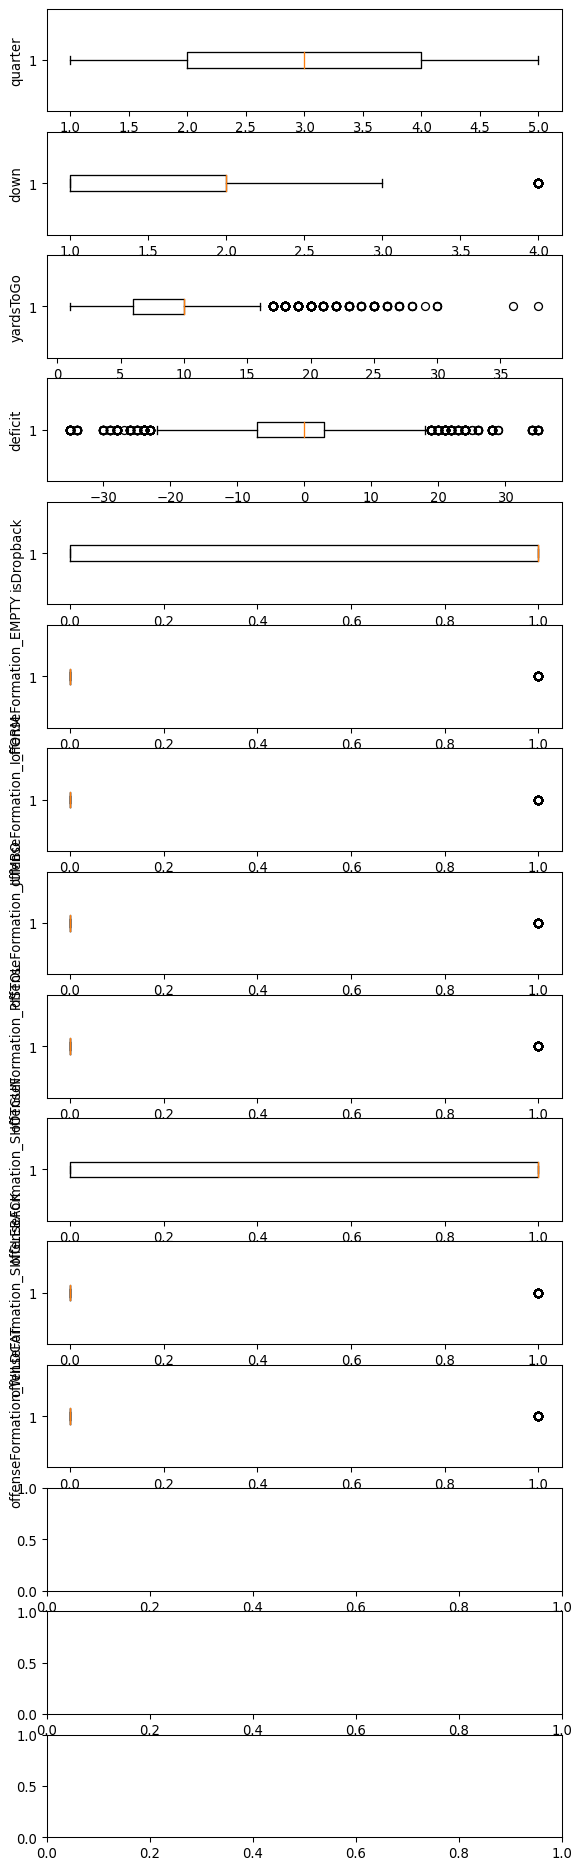

In [539]:
fig, axs = plt.subplots(15,1,dpi=95, figsize=(7,25))
i = 0
for col in plays.columns:
    axs[i].boxplot(plays[col], vert=False)
    axs[i].set_ylabel(col)
    i+=1
plt.show()

In [447]:
# def remove_outliers(df, feature):
#     q1, q3 = np.percentile(df[feature], [25, 75])
#     iqr = q3 - q1

#     lower_bound = q1 - (1.5 * iqr)
#     upper_bound = q3 + (1.5 * iqr)

#     clean_data = df[(df[feature] >= lower_bound) 
#                     & (df[feature] <= upper_bound)]
#     return clean_data

consider 1 hot encoding quarters, downs.

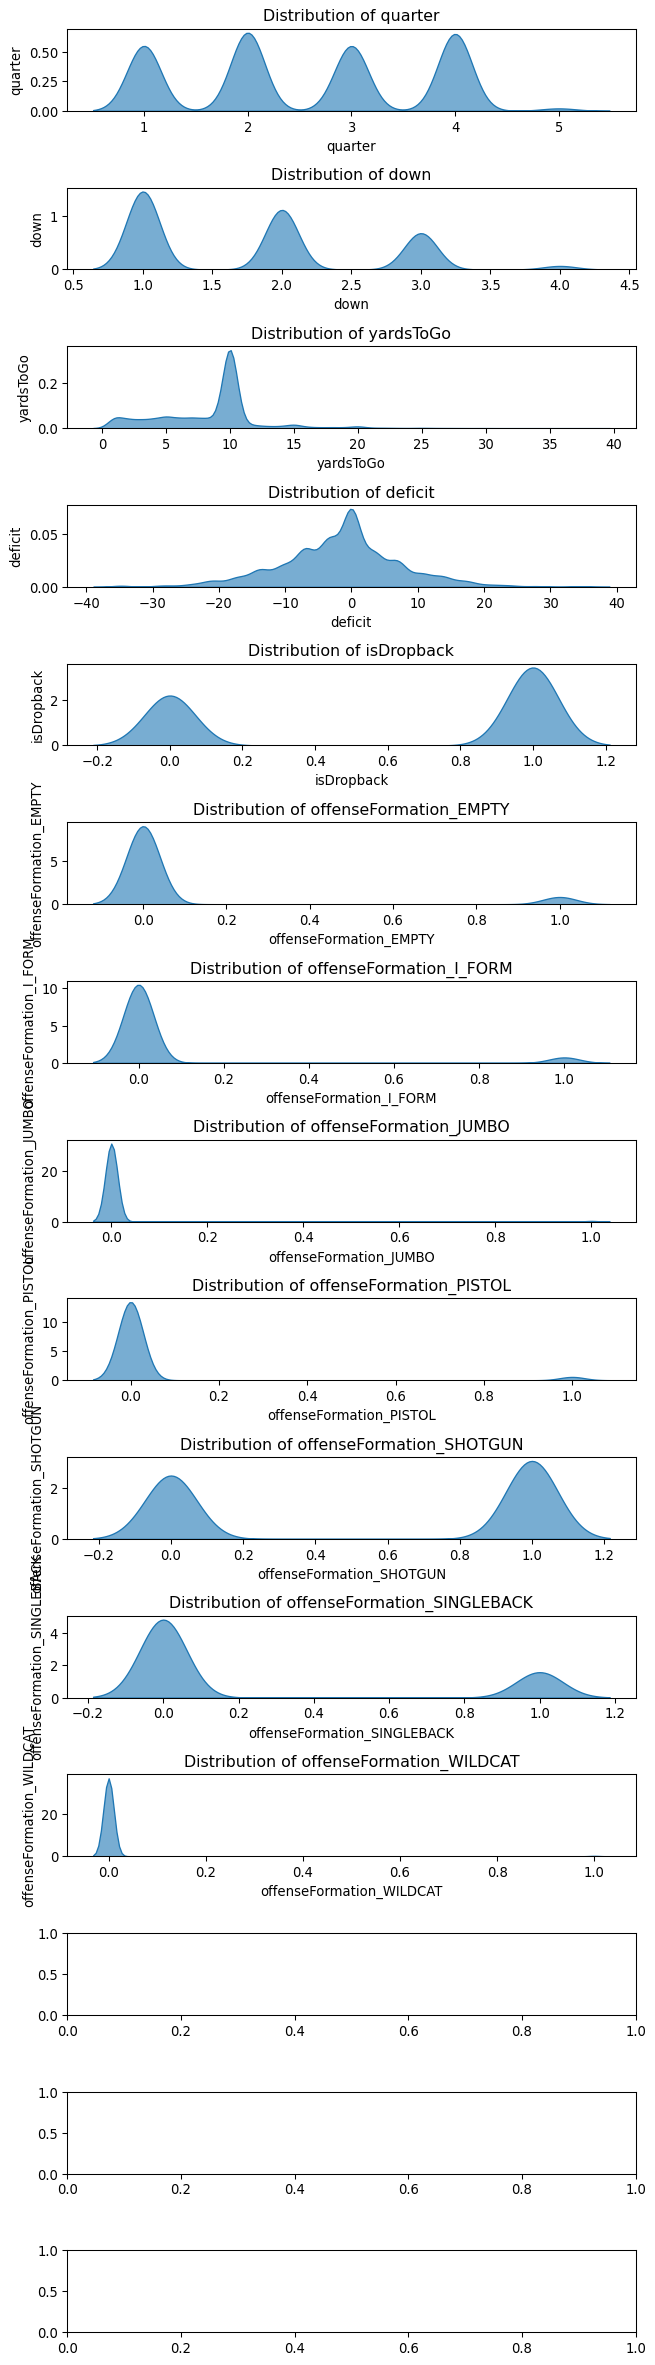

In [540]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(15, 1, dpi=95, figsize=(7, 25))

for i, col in enumerate(plays.columns):
    sns.kdeplot(plays[col], ax=axs[i], fill=True, alpha=0.6)  
    axs[i].set_ylabel(col)
    axs[i].set_title(f'Distribution of {col}')

plt.tight_layout()  
plt.show()


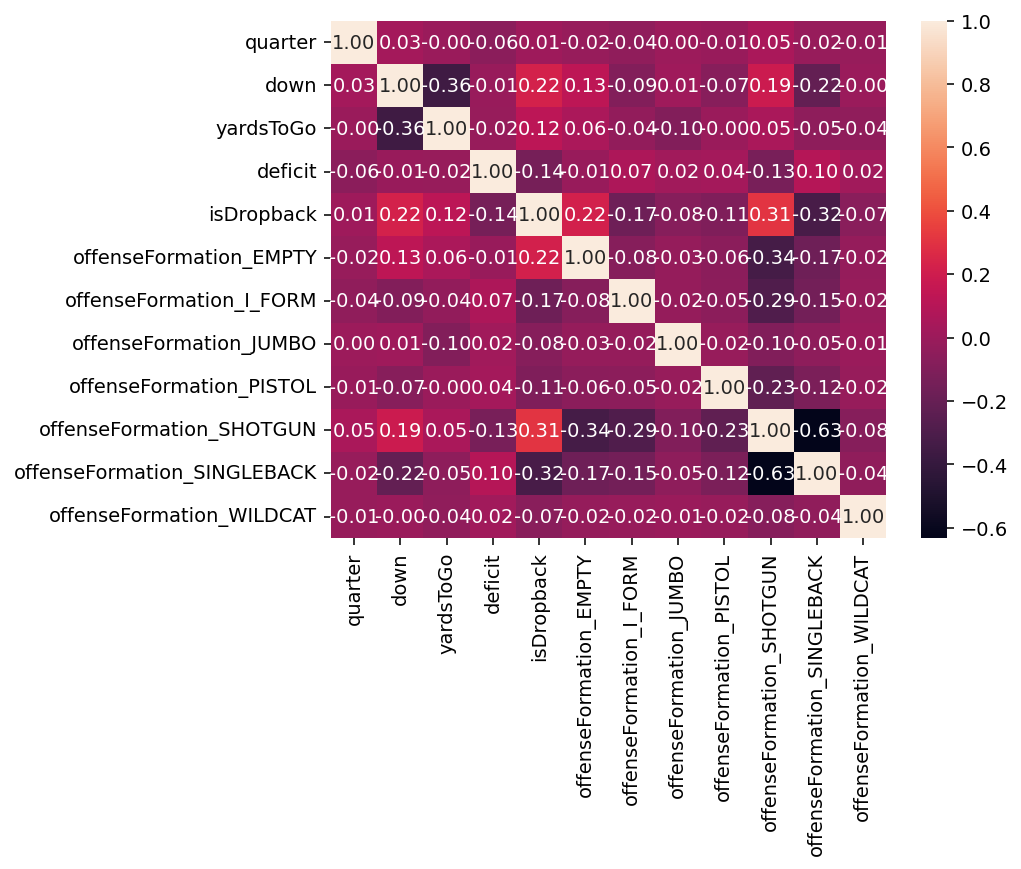

In [541]:
corr = plays.corr()
plt.figure(dpi=140)
sns.heatmap(plays.corr(), annot=True, fmt= '.2f')
plt.show()

might want to drop outliers? come back to that based on results...

In [542]:
corr['isDropback'].sort_values(ascending = False)

isDropback                     1.000000
offenseFormation_SHOTGUN       0.309035
down                           0.222427
offenseFormation_EMPTY         0.220955
yardsToGo                      0.121166
quarter                        0.007283
offenseFormation_WILDCAT      -0.069870
offenseFormation_JUMBO        -0.080465
offenseFormation_PISTOL       -0.107812
deficit                       -0.139801
offenseFormation_I_FORM       -0.173199
offenseFormation_SINGLEBACK   -0.322752
Name: isDropback, dtype: float64

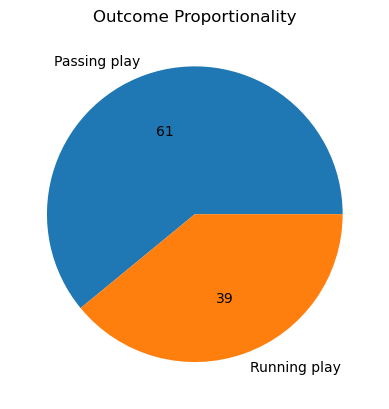

In [543]:

plt.pie(plays['isDropback'].value_counts(), 
        labels= ['Passing play', 'Running play'], 
        autopct='%.f')
plt.title('Outcome Proportionality')
plt.show()

In [555]:
X = plays.drop(columns = ['isDropback'])
Y = plays['isDropback']
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15936 entries, 0 to 16123
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   quarter                      15936 non-null  int64  
 1   down                         15936 non-null  int64  
 2   yardsToGo                    15936 non-null  int64  
 3   deficit                      15936 non-null  float64
 4   offenseFormation_EMPTY       15936 non-null  int64  
 5   offenseFormation_I_FORM      15936 non-null  int64  
 6   offenseFormation_JUMBO       15936 non-null  int64  
 7   offenseFormation_PISTOL      15936 non-null  int64  
 8   offenseFormation_SHOTGUN     15936 non-null  int64  
 9   offenseFormation_SINGLEBACK  15936 non-null  int64  
 10  offenseFormation_WILDCAT     15936 non-null  int64  
dtypes: float64(1), int64(10)
memory usage: 2.0 MB


In [556]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler


scaler = StandardScaler()
# scaler = RobustScaler()

# print(scaler.fit(X))
X = scaler.fit_transform(X)

split data

In [557]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

SGD Logistic regression classifier

In [547]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=1000)
clf.fit(X_train, y_train)

res = clf.predict(X_test)
accuracy = accuracy_score(y_test, res)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.74


Logistic regression classifier

In [548]:
from sklearn.linear_model import LogisticRegression
lclf = LogisticRegression(random_state=42).fit(X_train, y_train)

lres = lclf.predict(X_test)
acc = accuracy_score(y_test, lres)
print(f'Accuracy: {acc:.2f}')


Accuracy: 0.74


decision tree classifier

In [549]:
from sklearn import tree

tclf = tree.DecisionTreeClassifier().fit(X_train, y_train)

tres =tclf.predict(X_test)
t_acc = accuracy_score(y_test, tres)
print(f'Accuracy: {t_acc:.2f}')

Accuracy: 0.70


In [550]:
from sklearn.naive_bayes import GaussianNB

nbclf = GaussianNB().fit(X_train, y_train)
nbres = nbclf.predict(X_test)
nb_acc = accuracy_score(y_test, nbres)
print(f'Accuracy: {nb_acc:.2f}')

Accuracy: 0.74


In [570]:
from sklearn.ensemble import HistGradientBoostingClassifier
hclf = HistGradientBoostingClassifier(max_iter=1000).fit(X_train, y_train)
hres = hclf.predict(X_test)
h_acc = accuracy_score(y_test, hres)
print(f'Accuracy: {h_acc:.2f}')

Accuracy: 0.75


In [583]:
from sklearn.ensemble import GradientBoostingClassifier

gbclf = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=2, random_state=0).fit(X_train, y_train)
gbres = gbclf.predict(X_test)
gb_acc = accuracy_score(y_test, gbres)
print(f'Accuracy: {gb_acc:.2f}')

Accuracy: 0.75
